# Charter school cluster analysis 

This notebook walks through an approach to conducting a cluster analysis on schools in Washington state.  I am still learning and I'm sure there are many ways to streamline the work or come up with better ways, deeper data and more insights to be gained.  Any and all feedback is welcome and appreciated

In [196]:
# Set environment for analysis
# Imports
import os
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set Directory
os.chdir('C:\\Users\\ted\\OneDrive - Viztric\\Clients\\Gates Foundation\\charter schools\\CharterData\\Yearly School District State Dataset\\')

In [197]:
#Import data from CSV file as created by Eric

df0 = pd.read_csv('Yearly School District State Dataset thinner.csv')
#display(df.head())

The next step is to filter the records in order to get a more distinct subset of data to model as a first pass.  To limit the scope the data is limited to "Organization Grade Level" of AllGrades, 2018-19 School year and groupings of Students of Color (SoC) and Low Income.  The goal is to create a dataset with only one record per school resulting in a cluster of schools.  Other grades or other categories can be included but I believe would need to be added as columns in order to create one record per school.  If we have more than one row per school, the cluster would be built off of the lower grain and is more difficult to interpret.  (at least to me at this point)

In [198]:
df_allgrades=[]
df_allgrades = df0[(df0['Organization Grade Level']=='AllGrades') & (df0['School Year']=='2018-19')
                   & (df0['Student Group'].isin(['Low-Income','SoC'])) ]
               
df_allgrades.head()

,LEA Code,LEA Name,School Code,School Name,School Year,Organization Grade Level,Student Group,Student Group Category,Enrollment Percent Num,Enrollment Percent Den,...,SBA ELA 3Y Average Percent Num,SBA ELA 3Y Average Percent Den,SBA ELA 3Y Average Percent,SBA Math Met Percent Num,SBA Math Met Percent Den,SBA Math Percent Met,SBA Math 3Y Average Percent Num,SBA Math 3Y Average Percent Den,SBA Math 3Y Average Percent,Charter School?
1765,1147,Othello School District,2902,Lutacaga Elementary,2018-19,AllGrades,Low-Income,Student Demographics,573,642,...,56.66667,257.3333,0.220207,94,304,0.309210,76.66666,257.0000,0.298314,No
1773,1147,Othello School District,2902,Lutacaga Elementary,2018-19,AllGrades,SoC,Race,615,642,...,71.66666,286.6667,0.250000,112,327,0.342508,98.66666,286.3333,0.344587,No
1774,1147,Othello School District,2902,Lutacaga Elementary,2018-19,AllGrades,SoC,SoC,615,642,...,71.66666,286.6667,0.250000,112,327,0.342508,98.66666,286.3333,0.344587,No
1937,1147,Othello School District,2961,Hiawatha Elementary School,2018-19,AllGrades,Low-Income,Student Demographics,550,627,...,79.66666,277.6667,0.286915,111,342,0.324561,95.66666,278.0000,0.344125,No
1955,1147,Othello School District,2961,Hiawatha Elementary School,2018-19,AllGrades,SoC,Race,553,627,...,77.33334,274.3333,0.281896,99,331,0.299094,94.00000,274.6667,0.342233,No


Create Enrollment Percent column.  There is an error warning I need to investigate how to resolve.

In [199]:
df_allgrades['Enrollment Percent'] = df_allgrades['Enrollment Percent Num']/df_allgrades['Enrollment Percent Den']

C:\Users\ted\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Create a smaller, thinner, dataset

In [200]:
df_allgrades_thin= df_allgrades[['School Code', 'Student Group','Enrollment Percent','SBA ELA 3Y Average Percent','SBA Math 3Y Average Percent']]
df_allgrades_thin.head()

,School Code,Student Group,Enrollment Percent,SBA ELA 3Y Average Percent,SBA Math 3Y Average Percent
1765,2902,Low-Income,0.892523,0.220207,0.298314
1773,2902,SoC,0.957944,0.250000,0.344587
1774,2902,SoC,0.957944,0.250000,0.344587
1937,2961,Low-Income,0.877193,0.286915,0.344125
1955,2961,SoC,0.881978,0.281896,0.342233


In [201]:
#drop any duplicate records from dataset - Will delete those that may be remnants from columns that have been removed
df_allgrades_thin.drop_duplicates()

,School Code,Student Group,Enrollment Percent,SBA ELA 3Y Average Percent,SBA Math 3Y Average Percent
1765,2902,Low-Income,0.892523,0.220207,0.298314
1773,2902,SoC,0.957944,0.250000,0.344587
1937,2961,Low-Income,0.877193,0.286915,0.344125
1955,2961,SoC,0.881978,0.281896,0.342233
2022,3015,Low-Income,0.798748,0.438596,0.135566
...,...,...,...,...,...
297250,4506,Low-Income,0.515358,0.487603,0.382255
297259,4506,SoC,0.443686,0.530195,0.438398
297350,2389,SoC,0.937500,0.129794,0.091445
297532,2506,SoC,0.947955,0.146958,0.158257


Student Group is pivoted to columns to get dataset to one row per School.  School Code is set as the index, effectively removing it from the results enabling the use of only features for PCA and cluster analysis

In [202]:
pivot = df_allgrades_thin.pivot_table(columns='Student Group',index='School Code'
                             , values=['Enrollment Percent','SBA ELA 3Y Average Percent','SBA Math 3Y Average Percent']).fillna(0)
pivot.head()

Enrollment Percent           SBA ELA 3Y Average Percent  \
Student Group         Low-Income       SoC                 Low-Income   
School Code                                                             
1516                    0.398649  0.000000                   0.400000   
1537                    0.589744  0.000000                   0.284091   
1539                    0.398773  0.619632                   0.735849   
1567                    0.000000  0.444444                   0.000000   
1579                    0.267081  0.519669                   0.586806   

                        SBA Math 3Y Average Percent            
Student Group       SoC                  Low-Income       SoC  
School Code                                                    
1516           0.000000                    0.000000  0.000000  
1537           0.000000                    0.000000  0.000000  
1539           0.740260                    0.509434  0.629213  
1567           0.000000                    0.000000  0.000000  
1579           0.621381                    0.500000  0.559020

After pivoting, the column names are hierarchical and need to be combined into one column for ease of use (and that I can't figure out how filter data with combined column names)

In [203]:
pivot.columns = ["_".join((j,k)) for j,k in pivot.columns]
pivot.reset_index()

,School Code,Enrollment Percent_Low-Income,Enrollment Percent_SoC,SBA ELA 3Y Average Percent_Low-Income,SBA ELA 3Y Average Percent_SoC,SBA Math 3Y Average Percent_Low-Income,SBA Math 3Y Average Percent_SoC
0,1516,0.398649,0.000000,0.400000,0.000000,0.000000,0.000000
1,1537,0.589744,0.000000,0.284091,0.000000,0.000000,0.000000
2,1539,0.398773,0.619632,0.735849,0.740260,0.509434,0.629213
3,1567,0.000000,0.444444,0.000000,0.000000,0.000000,0.000000
4,1579,0.267081,0.519669,0.586806,0.621381,0.500000,0.559020
...,...,...,...,...,...,...,...
1832,5524,0.116352,0.314465,0.000000,0.000000,0.000000,0.000000
1833,5534,0.000000,0.228700,0.000000,0.000000,0.000000,0.000000
1834,5541,0.348485,0.000000,0.000000,0.000000,0.000000,0.000000
1835,5545,0.330065,0.000000,0.000000,0.000000,0.000000,0.000000


The pivoted data frame "pivot" is assigned to the df dataframe because df was used in subsequent view created in past iterations and rather than change all reference, I assigned back to df

In [204]:
df=pivot

In [205]:
#confirming proper column names and using to cut and paste into lower step
df.columns


Index(['Enrollment Percent_Low-Income', 'Enrollment Percent_SoC',
       'SBA ELA 3Y Average Percent_Low-Income',
       'SBA ELA 3Y Average Percent_SoC',
       'SBA Math 3Y Average Percent_Low-Income',
       'SBA Math 3Y Average Percent_SoC'],
      dtype='object')

Show a histogram of all of the elements in the dataframe

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027246867E80>,
      dtype=object)

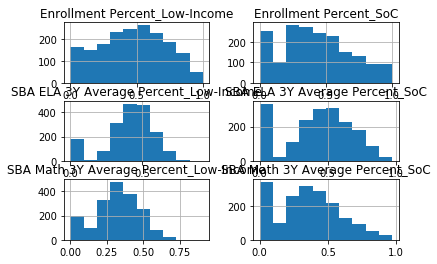

In [206]:
df.hist()

Principal Component Analysis (PCA) is used as a dimensionality reduction technique to take multiple dimensions and reduce them down to only the principal components that can be used in subsequent steps.  The impacts of this will need to be evaluated further to understand

In my research I learned different ways to conduct PCA.  I'm not sure of the impacts between this version and prior version.  Need to research

In [207]:
import plotly.express as px
from sklearn.decomposition import PCA

df2 = df
features = ['Enrollment Percent_Low-Income', 'Enrollment Percent_SoC',
       'SBA ELA 3Y Average Percent_Low-Income',
       'SBA ELA 3Y Average Percent_SoC',
       'SBA Math 3Y Average Percent_Low-Income',
       'SBA Math 3Y Average Percent_SoC']

pca = PCA(n_components=3)
components = pca.fit_transform(df2[features])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(3),
    title=f'Total Explained Variance: {total_var:.2f}%'
)
fig.update_traces(diagonal_visible=True)
fig.show()

#Source of chart https://plotly.com/python/pca-visualization/

Next step is to use KMeans to determine the number of clusters based on the inertias.  The point at the bend in the curve in chart below determines best number of clusters to used based on the data.  In this case 5 was chosen

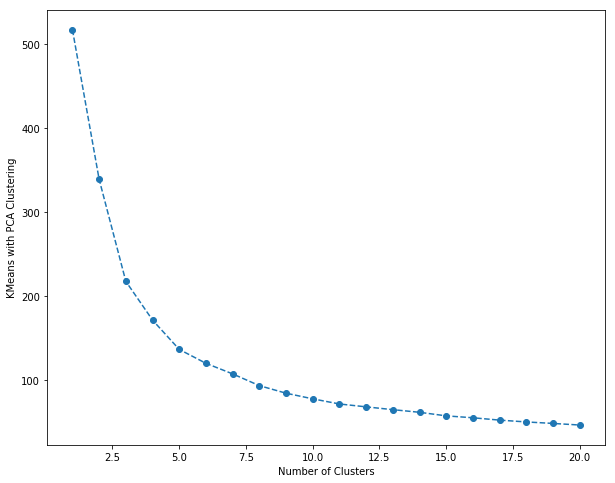

In [208]:
#fit the KMeans with results from PCA
from sklearn.cluster import KMeans
wcss=[]
for i in range(1,21):
    kmeans_pca=KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(components)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(10,8))
plt.plot(range(1,21),wcss,marker='o',linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('KMeans with PCA Clustering')
plt.show()

In [209]:
kmeans_pca = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans_pca.fit(components)

KMeans(n_clusters=5, random_state=42)

This step takes the results of the components in KMeans and combines with the original dataframe to create a dataframe that can be exported for further analysis

In [210]:
df_segm_pca_kmeans = pd.concat([df.reset_index(drop=False),pd.DataFrame(components)],axis=1)
df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2','Component 3']
df_segm_pca_kmeans['Segment KMeans PCA'] = kmeans_pca.labels_
df_segm_pca_kmeans.reset_index()
df_segm_pca_kmeans.head()

,School Code,Enrollment Percent_Low-Income,Enrollment Percent_SoC,SBA ELA 3Y Average Percent_Low-Income,SBA ELA 3Y Average Percent_SoC,SBA Math 3Y Average Percent_Low-Income,SBA Math 3Y Average Percent_SoC,Component 1,Component 2,Component 3,Segment KMeans PCA
0,1516,0.398649,0.000000,0.400000,0.000000,0.000000,0.000000,-0.603917,-0.410769,0.115213,3
1,1537,0.589744,0.000000,0.284091,0.000000,0.000000,0.000000,-0.689720,-0.292974,0.068243,3
2,1539,0.398773,0.619632,0.735849,0.740260,0.509434,0.629213,0.532108,0.102228,-0.200470,2
3,1567,0.000000,0.444444,0.000000,0.000000,0.000000,0.000000,-0.482804,-0.192408,0.691764,4
4,1579,0.267081,0.519669,0.586806,0.621381,0.500000,0.559020,0.406593,-0.039373,-0.050844,2


Adds a "Segment" column to rename the index numbers to other values.  The values first, second, etc can be named anything we want.

In [211]:
df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment KMeans PCA'].map({0:'first', 1:'second',2:'third',3:'fourth',4:
                                                                             'fifth'})

Creates a correlation matrix to show the relationsips between all of the various features.

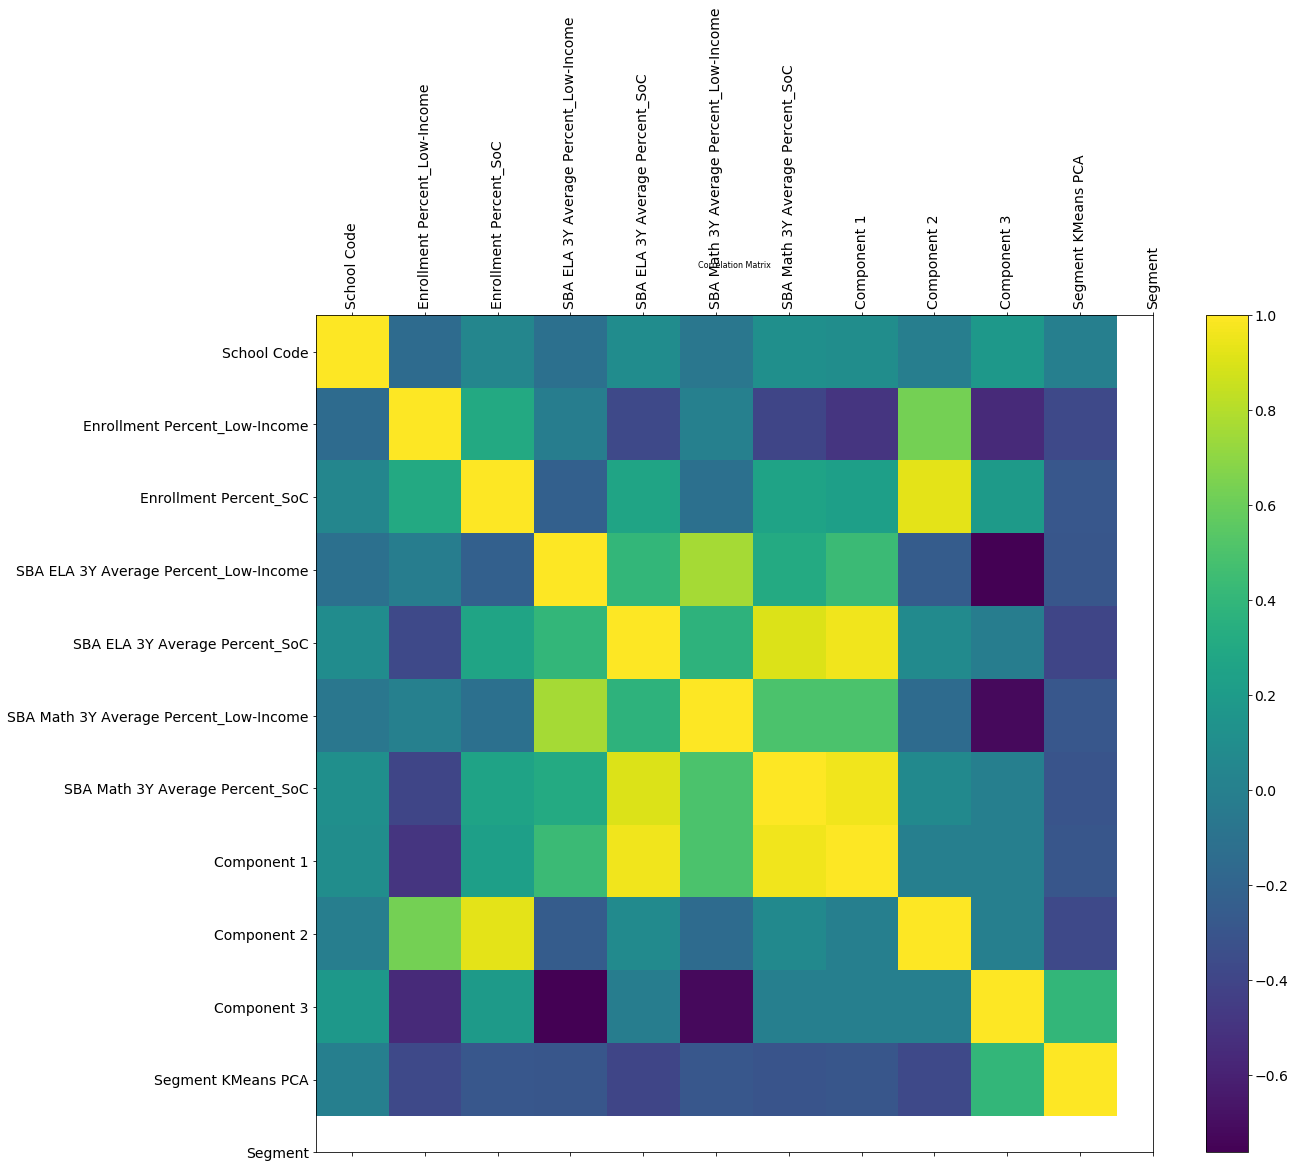

In [212]:
import matplotlib.pyplot as plt

df_merged = df_segm_pca_kmeans
#plt.matshow(df_merged.corr())
#plt.show()

f = plt.figure(figsize=(19, 15))
plt.matshow(df_merged.corr(), fignum=f.number)
plt.xticks(range(df_merged.shape[1]), df_merged.columns, fontsize=14, rotation=90)
plt.yticks(range(df_merged.shape[1]), df_merged.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=8);

The results dataframe is merged back with the original dataframe to bring the school code back in for future integration

In [213]:
df2 = df_merged.merge(df)
df2.head()

,School Code,Enrollment Percent_Low-Income,Enrollment Percent_SoC,SBA ELA 3Y Average Percent_Low-Income,SBA ELA 3Y Average Percent_SoC,SBA Math 3Y Average Percent_Low-Income,SBA Math 3Y Average Percent_SoC,Component 1,Component 2,Component 3,Segment KMeans PCA,Segment
0,1516,0.398649,0.000000,0.400000,0.000000,0.000000,0.000000,-0.603917,-0.410769,0.115213,3,fourth
1,1537,0.589744,0.000000,0.284091,0.000000,0.000000,0.000000,-0.689720,-0.292974,0.068243,3,fourth
2,1539,0.398773,0.619632,0.735849,0.740260,0.509434,0.629213,0.532108,0.102228,-0.200470,2,third
3,1567,0.000000,0.444444,0.000000,0.000000,0.000000,0.000000,-0.482804,-0.192408,0.691764,4,fifth
4,1579,0.267081,0.519669,0.586806,0.621381,0.500000,0.559020,0.406593,-0.039373,-0.050844,2,third


Step to bring in information about schools to add School Name, Lat, Long and other features of a school

In [214]:
GeoCodeData = pd.read_excel(r'C:\Users\ted\Viztric Dropbox\Ted Corbett\Gates - Charter Assessment Analytics\Data\School and Demographic Data\School and Demographic Dimension - GeoCoded.xlsx')
GeoCodeData.head()  

,RecordID,ESDCode,ESDName,LEACode,LEACodeForCharterComparison,LEAName,LEANameForCharterComparison,SchoolCode,School Name,PrincipalName,...,CASS_City,CASS_Plus4,CASS_State,CASS_ZIP,CASS_PostalCode,Lat,Lon,GeoLevel,CensusId,Z9_Census_TRACT
0,1,18801,Olympic Educational Service District 114,5402,5402,Quillayute Valley School District,Quillayute Valley School District,1500,Forks Alternative School,Cindy Feasel,...,Forks,9028.0,WA,98331.0,98331.0,47.946647,-124.384059,Street,5.300900e+14,NaN
1,2,17801,Puget Sound Educational Service District 121,17410,17410,Snoqualmie Valley School District,Snoqualmie Valley School District,1502,Two Rivers School,Rhonda L Schmidt,...,North Bend,9451.0,WA,98045.0,98045.0,47.496070,-121.782573,Street,5.303303e+14,NaN
2,3,4801,North Central Educational Service District 171,13144,13144,Quincy School District,Quincy School District,1506,Quincy Innovation Academy,Kathie Brown,...,Quincy,1201.0,WA,98848.0,98848.0,47.234385,-119.854718,Street,5.302501e+14,NaN
3,4,39801,Educational Service District 105,39202,39202,Toppenish School District,Toppenish School District,1508,Computer Academy Toppenish High School,Enrique Romero,...,Toppenish,9100.0,WA,98948.0,98948.0,46.377714,-120.335721,Street,5.307794e+14,NaN
4,5,17801,Puget Sound Educational Service District 121,27403,27403,Bethel School District,Bethel School District,1510,Challenger High School,Jeff Johnson,...,Spanaway,8316.0,WA,98387.0,98387.0,47.092759,-122.428391,Street,5.305307e+14,NaN


Create a smaller dataframe to only bring in relevant values to merge 

In [215]:
GeoCodeData_local_thin = GeoCodeData[['SchoolCode','School Name','Lat','Lon']]

Merge the Cluster dataset with the GeoCodeData to create a complete list per school

In [216]:
df_kmeans_pca_geo = df2.merge(GeoCodeData_local_thin, left_on='School Code', right_on='SchoolCode', how='inner')
df_kmeans_pca_geo.head()

,School Code,Enrollment Percent_Low-Income,Enrollment Percent_SoC,SBA ELA 3Y Average Percent_Low-Income,SBA ELA 3Y Average Percent_SoC,SBA Math 3Y Average Percent_Low-Income,SBA Math 3Y Average Percent_SoC,Component 1,Component 2,Component 3,Segment KMeans PCA,Segment,SchoolCode,School Name,Lat,Lon
0,1516,0.398649,0.000000,0.400000,0.000000,0.000000,0.000000,-0.603917,-0.410769,0.115213,3,fourth,1516,Henderson Bay Alt High School,47.333706,-122.602961
1,1537,0.589744,0.000000,0.284091,0.000000,0.000000,0.000000,-0.689720,-0.292974,0.068243,3,fourth,1537,State Street High School,48.503397,-122.227771
2,1539,0.398773,0.619632,0.735849,0.740260,0.509434,0.629213,0.532108,0.102228,-0.200470,2,third,1539,CHOICE Academy,47.438509,-122.324477
3,1567,0.000000,0.444444,0.000000,0.000000,0.000000,0.000000,-0.482804,-0.192408,0.691764,4,fifth,1567,Eagle Peak at Pratt,47.653457,-117.312141
4,1579,0.267081,0.519669,0.586806,0.621381,0.500000,0.559020,0.406593,-0.039373,-0.050844,2,third,1579,Tops K-8 School,47.642562,-122.324406


Export the final dataframe to a csv to be used for Tableau

In [217]:
df_kmeans_pca_geo.to_csv('df_kmeans_pca_geo.csv')